# Building a convnet for ✊✋✌
This presents how to build a convnet from scratch to classify images of rock-paper-scissors.  It is meant as a teaching activity to demonstrate the following concepts in practice:
- how images are represented and handled in software
- how to prepare a machine learning dataset
- how a full machine learning pipeline looks
- data preprocessing
- data augmentation and its importance in a 
- overfitting, underfitting

We use the high-level deep learning library Keras, but the concepts are general and we don't put much focus on the specifics of the code.

## Step 0: defining the problem
What problem do we want to solve, exactly?  We want to build a piece of software that, given an image as input that represents an hand making one of the three ✊✋✌ gestures, produces as output a classification of the image in one of the three classes.

In the following, we will adopt this convention
- class 0 is ✊ rock
- class 1 is ✋ paper
- class 2 is ✌ scissors

## Step 1: building a dataset
We are starting from scratch, so we need to shoot our own dataset; the best option is that multiple students/groups shoot plenty of images in parallel and then the data is somehow collected.  Whatever the process, in the end we want to have all pics in three different directories, one per class.  Format can be either jpg or png, and landscape/portrait, aspect ratio and resolution don't matter and can be mixed.

With some attention to logistics, this can be done in about 10-30 minutes.

Guidelines for shooting images. 
- We don't need high resolution: use the lowest resolution/quality allowed by the phone (this reduces the size of the dataset and speeds up data transfer).
- The hand must be more or less in the center of the image; it should not fill the whole image, but it should not be too small either.  ![caption](figures/guidelines.jpg)
- we want the dataset to represent as much variability as possible: if we want the classifier to work for all hand orientations, try to have examples for all of them; if we want to handle many different lightling conditions, try to have some pictures for different lightings;
- avoid poses that are ambiguous, unless you want to make your job harder: e.g., don't include in the dataset images of paper or scissors taken from the side;
- avoid having two images in the dataset that are almost the same: change the camera and hand pose at least a little bit; this is important because in the following code we randomly split training and testing data.

Remember that we need the images for each class to be in its own directory. To make this simpler, it helps to shoot first all images of rock, then all images of paper, then all images of scissors, and finally sort the images by time in the file manager and group them accordingly.

Place all images in three directories named `c0/`, `c1/`, and `c2/`.  Make sure that each directory only contains image files.

## Step 2: read in images and have a look at them
Let's first import what we need

In [1]:
%matplotlib inline

# General imports
import matplotlib.pyplot as plt
import pathlib
import skimage
import skimage.transform
import skimage.viewer
import pandas as pd
import numpy as np
import time
import keras.utils.np_utils
from tqdm import tqdm

# Setup to show interactive jupyter widgets
from IPython.display import Image, display
from ipywidgets import interact, fixed
import ipywidgets as widgets
def imgplotList(i,data):
    plt.figure(figsize=(10,10))
    plt.imshow(data[i],interpolation="nearest")
    plt.show()

C:\Users\Fabrizio\Anaconda3\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
Using TensorFlow backend.


In [2]:
# Define where datasets are located
dataset_directory = pathlib.Path("..")/"datasets"/"final"

# Define which datasets we should consider.
# Each dataset is a directory withing dataset_directory
# and must contain three subdirectories: (c0, c1, c2) for (rock, paper, scissors).
dnames = ["D{}".format(n) for n in range(1,8)] + ["testing"]


# Now check the data
ddirs=[dataset_directory/dn for dn in dnames] # directories of the dataset
cdirs={}
for ddir in ddirs:
    cdirs.update({ddir/"c0":0,
                  ddir/"c1":1,
                  ddir/"c2":2})
names = ["rock", "paper", "scissors"]
for cdir,cdir_class in cdirs.items():
    assert(cdir.exists())
    print("Found directory {} containing class {}".format(cdir,names[cdir_class]))

Found directory ..\datasets\final\D6\c2 containing class scissors
Found directory ..\datasets\final\D3\c0 containing class rock
Found directory ..\datasets\final\D1\c0 containing class rock
Found directory ..\datasets\final\D4\c2 containing class scissors
Found directory ..\datasets\final\D3\c1 containing class paper
Found directory ..\datasets\final\testing\c1 containing class paper
Found directory ..\datasets\final\testing\c2 containing class scissors
Found directory ..\datasets\final\testing\c0 containing class rock
Found directory ..\datasets\final\D5\c1 containing class paper
Found directory ..\datasets\final\D7\c2 containing class scissors
Found directory ..\datasets\final\D4\c1 containing class paper
Found directory ..\datasets\final\D2\c1 containing class paper
Found directory ..\datasets\final\D7\c1 containing class paper
Found directory ..\datasets\final\D6\c0 containing class rock
Found directory ..\datasets\final\D4\c0 containing class rock
Found directory ..\datasets\final

Let's try to read the first image from the first directory, and visualize it.  Note that the tool allows you to zoom in order to see the individual pixels.

In [3]:
im = skimage.io.imread(list(list(cdirs.keys())[0].glob("*"))[0])
viewer=skimage.viewer.ImageViewer(im)
viewer.show()
# Note: you have to close the window to continue

[]

We now read in all images, cut the central square (with an edge as long as the shorter dimension), and resize it to 200x200 pixels.  Whatever the initial size and orientation of the images, we will end up with a bunch of 200x200 RGB squares in uint8.  These should be small enough that unless the dataset is huge, all should fit in memory.

We make a pandas dataframe with the data, with two columns:
* image: a $200 \times 200 \times 3$ uint8 numpy array
* label: on of 0, 1 or 2
* file: the full path of the image

In [4]:
imagesize = 200

dataset=[]

import warnings

for cdir,cn in tqdm(list(cdirs.items())):
    for f in list(cdir.glob("*")):
        try:
            im=skimage.io.imread(f)
        except (OSError, ValueError) as e:
            warnings.warn("ignoring {} due to exception {}".format(f,str(e)))
            continue
            
        h,w=im.shape[0:2] # height, width
        sz=min(h,w)
        im=im[(h//2-sz//2):(h//2+sz//2),(w//2-sz//2):(w//2+sz//2),:] # defines the central square        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            im=skimage.img_as_ubyte(skimage.transform.resize(im,(imagesize,imagesize))) # resize it to 500x500, whatever the original resolution
            
        dataset.append({
            "file":f,
            "label":cn,
            "image":im})
        
print("Done")

 38%|███▊      | 9/24 [00:17<00:29,  2.00s/it]C:\Users\Fabrizio\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring ..\datasets\final\D7\c2\.DS_Store due to exception cannot identify image file 'C:\\Users\\Fabrizio\\Documents\\GitHub\\rock-paper-scissors\\datasets\\final\\D7\\c2\\.DS_Store'
  if sys.path[0] == '':
 50%|█████     | 12/24 [00:27<00:27,  2.30s/it]C:\Users\Fabrizio\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring ..\datasets\final\D7\c1\.DS_Store due to exception cannot identify image file 'C:\\Users\\Fabrizio\\Documents\\GitHub\\rock-paper-scissors\\datasets\\final\\D7\\c1\\.DS_Store'
  if sys.path[0] == '':
 96%|█████████▌| 23/24 [00:53<00:02,  2.30s/it]C:\Users\Fabrizio\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: ignoring ..\datasets\final\D7\c0\.DS_Store due to exception cannot identify image file 'C:\\Users\\Fabrizio\\Documents\\GitHub\\rock-paper-scissors\\datasets\\final\\D7\\c0\\.DS_Store'
  

Done


We make a pandas dataframe for the dataset, and create a "dn" field containing the name of the dataset from which each image comes (as the name of the directory it was read from).

In [5]:
dataset=pd.DataFrame(dataset)
dataset["dn"]=dataset["file"].apply(lambda x: x.parent.parts[-2])

Here are 10 random rows from that dataset

In [6]:
dataset.sample(n=10)[["image","label","file","dn"]].style

,image,label,file,dn
525,"[[[ 48 37 26] [ 79 56 45] [130 93 83] ..., [ 75 65 50] [ 72 58 46] [ 73 59 48]] [[ 47 33 19] [101 75 63] [140 103 89] ..., [ 46 38 28] [ 54 43 31] [ 57 45 34]] [[ 74 56 41] [114 85 71] [146 108 92] ..., [ 16 12 7] [ 15 10 2] [ 22 17 8]] ..., [[ 61 61 59] [ 66 66 64] [ 69 69 67] ..., [ 18 17 31] [ 13 12 29] [ 16 15 33]] [[ 66 64 65] [ 67 67 65] [ 73 72 69] ..., [ 26 23 37] [ 23 22 36] [ 23 22 37]] [[ 69 67 68] [ 73 72 70] [ 72 71 67] ..., [ 22 19 32] [ 27 24 38] [ 53 51 65]]]",1,..\datasets\final\D5\c1\20140828_184410.jpg,D5
593,"[[[254 218 170] [255 219 170] [255 219 171] ..., [ 68 65 62] [ 66 65 60] [ 66 63 58]] [[255 219 171] [254 219 171] [255 219 171] ..., [ 67 66 62] [ 64 63 60] [ 67 63 58]] [[251 218 169] [254 218 169] [255 219 169] ..., [ 66 64 57] [ 66 62 60] [ 64 58 57]] ..., [[129 102 110] [138 112 119] [160 133 138] ..., [192 164 102] [193 163 100] [192 162 99]] [[140 112 119] [152 126 132] [141 115 123] ..., [193 166 104] [196 166 105] [192 162 103]] [[154 124 134] [137 106 115] [121 89 100] ..., [195 166 108] [194 166 105] [195 166 108]]]",2,..\datasets\final\D7\c2\20180219111213-Scissors-31b718cd52609698.jpg,D7
761,"[[[148 150 149] [149 151 150] [152 154 153] ..., [137 136 132] [136 137 132] [135 136 131]] [[148 150 149] [150 152 151] [151 153 152] ..., [138 137 133] [139 138 134] [137 136 132]] [[149 151 150] [150 152 151] [152 154 153] ..., [138 137 133] [139 138 136] [136 135 133]] ..., [[134 135 137] [135 136 138] [136 137 139] ..., [ 99 99 101] [ 98 98 100] [ 97 97 99]] [[132 133 135] [133 134 136] [134 135 137] ..., [ 99 99 99] [ 98 97 98] [ 98 96 97]] [[132 133 135] [133 134 136] [134 135 137] ..., [ 98 98 98] [ 97 96 97] [ 95 93 94]]]",1,..\datasets\final\D4\c1\20170802_161238.jpg,D4
356,"[[[164 169 149] [166 171 151] [169 174 154] ..., [142 156 157] [143 155 157] [142 153 155]] [[168 173 153] [168 173 153] [169 174 154] ..., [146 156 158] [144 154 156] [145 155 157]] [[167 172 152] [168 173 153] [170 175 155] ..., [148 158 159] [148 156 158] [148 156 159]] ..., [[155 121 75] [156 122 76] [157 123 75] ..., [135 135 137] [136 136 138] [135 135 137]] [[154 118 70] [156 121 74] [152 119 71] ..., [133 133 135] [134 134 136] [134 134 136]] [[153 117 69] [154 119 71] [149 117 68] ..., [133 133 135] [133 133 135] [131 131 133]]]",1,..\datasets\final\D3\c1\20170705_121834.jpg,D3
310,"[[[156 157 151] [155 156 151] [159 160 155] ..., [154 156 155] [154 157 156] [153 156 155]] [[157 158 152] [157 158 153] [160 161 156] ..., [156 158 158] [155 157 156] [153 155 154]] [[157 159 152] [159 161 156] [159 161 156] ..., [157 159 158] [158 158 158] [155 155 155]] ..., [[ 80 55 48] [ 82 54 48] [ 83 53 47] ..., [126 126 128] [126 125 130] [128 127 132]] [[ 80 59 50] [ 82 57 50] [ 82 56 49] ..., [123 122 127] [128 127 132] [126 125 131]] [[ 84 64 56] [ 87 64 56] [ 83 58 51] ..., [124 123 128] [123 122 128] [122 121 127]]]",2,..\datasets\final\D4\c2\20170802_151501.jpg,D4
631,"[[[211 213 212] [206 210 211] [205 207 209] ..., [143 144 115] [169 181 153] [109 127 83]] [[206 210 211] [205 209 214] [204 206 208] ..., [204 207 190] [149 156 120] [152 163 128]] [[202 205 208] [202 206 210] [217 219 219] ..., [167 175 148] [153 157 133] [142 156 121]] ..., [[ 19 25 37] [ 17 28 37] [ 26 35 47] ..., [ 67 107 74] [ 53 82 40] [ 67 90 51]] [[ 26 32 42] [ 25 33 42] [ 25 33 43] ..., [ 58 112 103] [ 60 103 45] [ 70 105 54]] [[ 13 20 30] [ 25 32 42] [ 21 30 39] ..., [ 51 97 86] [ 73 121 74] [ 65 104 51]]]",2,..\datasets\final\D7\c2\20180219134400-Scissors-755f029b7e2a43e1.jpg,D7
1735,"[[[ 90 86 92] [ 93 89 96] [ 94 93 101] ..., [ 28 26 38] [ 23 22 31] [ 24 24 31]] [[ 34 30 27] [ 40 36 39] [ 49 45 48] ..., [ 23 21 32] [ 19 19 28] [ 29 31 38]] [[ 34 30 28] [ 40 35 34] [ 40 34 34] ..., [ 16 15 24] [ 28 31 42] [ 19 25 34]] ..., [[252 252 250] [254 253 251] [254 252 252] ..., [ 28 19 20] [ 34 24 28] [ 29 19 20]] [[254 252 247] [254 251 248] [249 243 241] ..., [ 36 26 27] [ 27 17 19] [ 34 22 25]] [[251 244 242] [250 242 240

Optionally, we can quickly scroll through the images in our dataset.

In [7]:
viewer=skimage.viewer.CollectionViewer([r[1]["image"] for r in dataset.iterrows()])
viewer.show()
# Note: you have to close the window to continue

[]

## Step 3: Prepare training and testing sets

How should we split training and testing data?  The code below implements a few options (run only one of the cells).

In [8]:
# Option one (hard): use all samples from dataset named "testing"
# which contains some images taken in the same days as D1--D4, but not contained in these dirs.
te_mask = dataset["dn"]=="testing"
dataset_te=dataset[te_mask]

In [9]:
# Option two (hard): test on all samples from one specific dataset
te_mask = dataset["dn"]=="D2"
dataset_te=dataset[te_mask]

In [10]:
# In any case, training samples are all other samples
dataset_tr=dataset.loc[dataset.index.difference(dataset_te.index)]

In [11]:
# Print a summary of how many training and testing images we have sampled
import collections
pd.DataFrame(index=[0,1,2],data=collections.OrderedDict((
    ("Class name",           names),
    ("# Training images", dataset_tr["label"].value_counts()),
    ("# Testing images",  dataset_te["label"].value_counts())))).set_index("Class name")

,# Training images,# Testing images
Class name,,
rock,543,69
paper,504,71
scissors,578,63


In [12]:
%matplotlib inline
examples=list(dataset_te["image"])
interact(
    imgplotList, 
    i=widgets.IntSlider(min=0,max=len(examples)-1, step=1, value=0,continuous_update=True), 
    data=fixed(examples))

<function __main__.imgplotList>

## Step 4: define what we feed to the Neural Network

In [13]:
im = dataset_tr.sample(1).iloc[0]["image"]
print(im.shape, im.dtype)

(200, 200, 3) uint8


In [14]:
# Take image and resize to a specified size
def transform_simple(im,sz):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        imr = skimage.transform.resize(im, (sz,sz))
    return imr

transform = transform_simple

In [15]:
# Take image and resize to a specified size, after applying data augmentation
def transform_complex(im,sz):
    if(np.random.rand()<0.5):
        im=np.fliplr(im)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tf1 = skimage.transform.SimilarityTransform(scale = 1 / im.shape[0])
        tf2 = skimage.transform.SimilarityTransform(translation=[-0.5, -0.5])
        tf3 = skimage.transform.SimilarityTransform(rotation=np.deg2rad(np.random.uniform(0,360)))
        tf4 = skimage.transform.SimilarityTransform(scale=np.random.uniform(1,1.6))
        tf5 = skimage.transform.SimilarityTransform(translation=np.array([0.5, 0.5])+np.random.uniform(-0.1,0.1,size=2))
        tf6 = skimage.transform.SimilarityTransform(scale=sz)
        imr = skimage.transform.warp(im, (tf1+(tf2+(tf3+(tf4+(tf5+tf6))))).inverse, output_shape=(sz,sz),mode="edge")
        imr = imr*np.random.uniform(0.9,1.1,size=(1,1,3))
        imr = np.clip(imr,0,1)
    return imr

transform = transform_complex

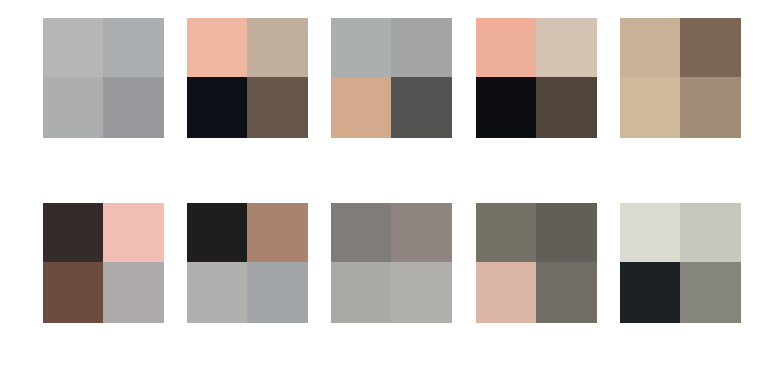

In [16]:
# The resolution challenge
@interact(sz = widgets.IntSlider(min=2,max=100),
          seed = widgets.IntSlider(min=0,max=100),
          reveal = widgets.widgets.ToggleButton(value=False,description='Reveal'))
def f(sz,seed,reveal):
    fig,axs = plt.subplots(nrows = 2, ncols = 5,figsize=(6,3),dpi=150)
    ims = dataset_tr.sample(len(axs.flatten()), random_state=sz*100+seed)
    for ax,(_,row) in zip(axs.flatten(),ims.iterrows()):
        ax.imshow(transform_simple(row["image"],sz))
        ax.axis("off")
        if(reveal):
            ax.set_title(names[row["label"]])
    #fig.tight_layout()

In [17]:
def sample(df,sz):
    r=df.sample(n=1)
    l=r["label"].iloc[0]
    im=r["image"].iloc[0]
    im=transform(im,sz)
    return im,l

def mkbatch(df,N,sz):
    X = []
    y = []
    for i in range(N):
        im,l=sample(df,sz)
        X.append(im)
        y.append(l)
    X=np.array(X).astype('float32')
    y=np.array(y)
    y=keras.utils.np_utils.to_categorical(y,3)
    return X,y

def generator(df,batch_size,sz):
    while True:
        X,y = mkbatch(df,batch_size,sz)
        yield (X,y)

In [18]:
b = mkbatch(dataset_tr,20,32)
b[1]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.]])

In [19]:
# Visualize 100 images from our input dataset
examples = list(mkbatch(dataset_tr,100,32)[0])
interact(imgplotList, i=widgets.IntSlider(min=0, max=len(examples)-1, step=1, value=0,continuous_update=False), data=fixed(examples))

<function __main__.imgplotList>

In [20]:
# Visualize 100 variations from our first input image (makes sense only if transform==transform_complex, i.e. if we are using data augmentation)
examples = list(mkbatch(dataset_tr.iloc[[0]],100,32)[0])
interact(imgplotList, i=widgets.IntSlider(min=0, max=len(examples)-1, step=1, value=0,continuous_update=False), data=fixed(examples))

<function __main__.imgplotList>

## Step 5: build and train the neural network

In [21]:
# Keras: Deep Learning library for Theano and TensorFlow
import keras
from keras.utils  import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout

# NN settings
patchsize          = 32
batch_size         = 32
pool_size          = (2,2) # size of pooling area for max pooling
kernel_size        = (3,3) # convolution kernel size

def makeModel(nb_filters):
    model = Sequential()
    model.add(Conv2D(nb_filters, kernel_size, input_shape=(patchsize,patchsize,3), padding = "same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Conv2D(nb_filters*2, kernel_size, padding = "same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Conv2D(nb_filters*4, kernel_size, padding = "same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(AveragePooling2D(pool_size = pool_size))
    model.add(Flatten())
    model.add(Dense(128)) # generate a fully connected layer wiht 128 outputs (arbitrary value)
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3)) # output layer
    model.add(Activation('softmax'))

    ## compile! network
    model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])

    return model

In [22]:
makeModel(128).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 512)         1180160   
__________

Build a set of 1000 testing instances taken from the testing dataset.

Note: "testing" in this case is synonym with "validation" and "evaluation"

In [23]:
(X_test,y_test) = mkbatch(dataset_te, 1000, patchsize)

# Prepare the logs directory, if it does not exist
(pathlib.Path(".")/"logs").mkdir(exist_ok=True)

While the network trains, we can monitor training loss/accuracy and testing loss/accuracy using tensorboard at http://0.0.0.0:6006

You may need to launch tensorboard first if it's not already running, by executing

`tensorboard --logdir=logs`

in a shell with the current working directory.  Check that you are within the proper conda environment, if applicable.

In [25]:
modelid = time.strftime("%Y%m%d%H%M%S")

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_acc',
        patience=50),
    keras.callbacks.ModelCheckpoint(
        filepath='model_checkpoint_best_{}.h5'.format(modelid),
        monitor='val_loss',
        save_best_only=True),
    keras.callbacks.TensorBoard(
        log_dir='./logs/'+modelid,
        histogram_freq=0, write_graph=False, write_images=False)
]

model = makeModel(32)
history=model.fit_generator(
                    generator(dataset_tr, batch_size, patchsize),
                    steps_per_epoch=50, 
                    epochs=5, 
                    verbose=1,
                    validation_data=(X_test,y_test),
                    callbacks=callbacks_list)

Epoch 1/5
50/50 [==============================] - ETA: 12s - loss: 1.0848 - acc: 0.34 - ETA: 9s - loss: 1.1017 - acc: 0.3750 - ETA: 9s - loss: 1.0891 - acc: 0.406 - ETA: 8s - loss: 1.0985 - acc: 0.406 - ETA: 8s - loss: 1.1241 - acc: 0.375 - ETA: 7s - loss: 1.1111 - acc: 0.385 - ETA: 7s - loss: 1.1187 - acc: 0.375 - ETA: 7s - loss: 1.1220 - acc: 0.363 - ETA: 6s - loss: 1.1211 - acc: 0.347 - ETA: 6s - loss: 1.1176 - acc: 0.356 - ETA: 6s - loss: 1.1191 - acc: 0.338 - ETA: 6s - loss: 1.1191 - acc: 0.328 - ETA: 6s - loss: 1.1190 - acc: 0.324 - ETA: 5s - loss: 1.1190 - acc: 0.319 - ETA: 5s - loss: 1.1183 - acc: 0.316 - ETA: 5s - loss: 1.1174 - acc: 0.316 - ETA: 5s - loss: 1.1157 - acc: 0.321 - ETA: 5s - loss: 1.1148 - acc: 0.322 - ETA: 5s - loss: 1.1141 - acc: 0.322 - ETA: 4s - loss: 1.1136 - acc: 0.325 - ETA: 4s - loss: 1.1131 - acc: 0.324 - ETA: 4s - loss: 1.1129 - acc: 0.322 - ETA: 4s - loss: 1.1121 - acc: 0.326 - ETA: 4s - loss: 1.1117 - acc: 0.324 - ETA: 4s - loss: 1.1110 - acc: 0.327 

50/50 [==============================] - ETA: 6s - loss: 1.0970 - acc: 0.343 - ETA: 6s - loss: 1.1064 - acc: 0.296 - ETA: 7s - loss: 1.1044 - acc: 0.312 - ETA: 6s - loss: 1.0985 - acc: 0.343 - ETA: 6s - loss: 1.0966 - acc: 0.350 - ETA: 7s - loss: 1.0915 - acc: 0.364 - ETA: 7s - loss: 1.0893 - acc: 0.370 - ETA: 7s - loss: 1.0922 - acc: 0.367 - ETA: 6s - loss: 1.0941 - acc: 0.368 - ETA: 6s - loss: 1.0895 - acc: 0.387 - ETA: 6s - loss: 1.0922 - acc: 0.380 - ETA: 6s - loss: 1.0896 - acc: 0.390 - ETA: 5s - loss: 1.0912 - acc: 0.382 - ETA: 5s - loss: 1.0916 - acc: 0.379 - ETA: 5s - loss: 1.0914 - acc: 0.383 - ETA: 5s - loss: 1.0894 - acc: 0.388 - ETA: 5s - loss: 1.0904 - acc: 0.382 - ETA: 4s - loss: 1.0897 - acc: 0.387 - ETA: 4s - loss: 1.0894 - acc: 0.388 - ETA: 4s - loss: 1.0896 - acc: 0.387 - ETA: 4s - loss: 1.0897 - acc: 0.388 - ETA: 4s - loss: 1.0895 - acc: 0.390 - ETA: 4s - loss: 1.0900 - acc: 0.388 - ETA: 4s - loss: 1.0895 - acc: 0.391 - ETA: 3s - loss: 1.0893 - acc: 0.393 - ETA: 3s -

After training our model, we can save it to disk

In [26]:
modelname = "input32"

# Save model to a file
keras.models.save_model(model,"{}.model".format(modelname))

# Also save the testing dataset (may be large) so we can pick up from here later 
dataset_te.to_pickle("{}.testingdata.pickle".format(modelname))

If you have time and want to experiment, you may train many networks exploring the parameter space

In [30]:
# Train many models
for filters in [1,2,4,8,16,32,48,64,96]:
    modelid = "filters{:03d}_timestamp{}".format(filters,time.strftime("%Y%m%d%H%M%S"))

    callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor='val_acc',
            patience=50),
        keras.callbacks.ModelCheckpoint(
            filepath='model_checkpoint_best_{}.h5'.format(modelid),
            monitor='val_loss',
            save_best_only=True),
        keras.callbacks.TensorBoard(
            log_dir='./logs/'+modelid,
            histogram_freq=0, write_graph=False, write_images=False)
    ]
    
    model = makeModel(filters)
    print(model.summary())
    print(model.count_params())

    history=model.fit_generator(
                        generator(dataset_tr, batch_size, patchsize),
                        steps_per_epoch=50, 
                        epochs=1, 
                        verbose=1,
                        validation_data=(X_test,y_test),
                        callbacks=callbacks_list)
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 32, 32, 1)         28        
_________________________________________________________________
activation_56 (Activation)   (None, 32, 32, 1)         0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 2)         20        
_________________________________________________________________
activation_57 (Activation)   (None, 16, 16, 2)         0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 8, 8, 2)           0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 8, 8, 4)           76        
__________

50/50 [==============================] - ETA: 9s - loss: 1.1009 - acc: 0.312 - ETA: 5s - loss: 1.0969 - acc: 0.406 - ETA: 5s - loss: 1.0964 - acc: 0.382 - ETA: 4s - loss: 1.0974 - acc: 0.368 - ETA: 4s - loss: 1.0973 - acc: 0.369 - ETA: 4s - loss: 1.0971 - acc: 0.379 - ETA: 4s - loss: 1.0975 - acc: 0.367 - ETA: 4s - loss: 1.0977 - acc: 0.361 - ETA: 4s - loss: 1.0992 - acc: 0.337 - ETA: 4s - loss: 1.0987 - acc: 0.343 - ETA: 3s - loss: 1.0989 - acc: 0.341 - ETA: 3s - loss: 1.0994 - acc: 0.338 - ETA: 3s - loss: 1.0995 - acc: 0.339 - ETA: 3s - loss: 1.0989 - acc: 0.352 - ETA: 3s - loss: 1.0986 - acc: 0.353 - ETA: 3s - loss: 1.0984 - acc: 0.352 - ETA: 3s - loss: 1.0987 - acc: 0.347 - ETA: 3s - loss: 1.0986 - acc: 0.350 - ETA: 3s - loss: 1.0987 - acc: 0.345 - ETA: 2s - loss: 1.0985 - acc: 0.349 - ETA: 2s - loss: 1.0987 - acc: 0.346 - ETA: 2s - loss: 1.0988 - acc: 0.347 - ETA: 2s - loss: 1.0986 - acc: 0.349 - ETA: 2s - loss: 1.0985 - acc: 0.350 - ETA: 2s - loss: 1.0980 - acc: 0.355 - ETA: 2s -

_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 3)                 387       
_________________________________________________________________
activation_75 (Activation)   (None, 3)                 0         
Total params: 22,931
Trainable params: 22,931
Non-trainable params: 0
_________________________________________________________________
None
22931
Epoch 1/1
50/50 [==============================] - ETA: 8s - loss: 1.1272 - acc: 0.281 - ETA: 4s - loss: 1.1069 - acc: 0.302 - ETA: 4s - loss: 1.1161 - acc: 0.273 - ETA: 4s - loss: 1.1169 - acc: 0.275 - ETA: 4s - loss: 1.1162 - acc: 0.270 - ETA: 4s - loss: 1.1122 - acc: 0.281 - ETA: 4s - loss: 1.1187 - acc: 0.261 - ETA: 4s - loss: 1.1152 - acc: 0.281 - ETA: 3s - loss: 1.1118 - acc: 0.293 - ETA: 3s - loss: 1.1106 - acc: 0.298 - ETA: 3s - loss: 1.1099 - a

_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
average_pooling2d_17 (Averag (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               65664     
_________________________________________________________________
activation_84 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 3)                 387       
_________________________________________________________________
activation

max_pooling2d_55 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
activation_92 (Activation)   (None, 16, 16, 128)       0         
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 8, 8, 256)         295168    
_________________________________________________________________
activation_93 (Activation)   (None, 8, 8, 256)         0         
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
average_pooling2d_19 (Averag (None, 2, 2, 256)         0         
__________

50/50 [==============================] - ETA: 40s - loss: 1.1431 - acc: 0.18 - ETA: 35s - loss: 1.3044 - acc: 0.28 - ETA: 33s - loss: 1.2472 - acc: 0.32 - ETA: 32s - loss: 1.2153 - acc: 0.33 - ETA: 31s - loss: 1.1958 - acc: 0.34 - ETA: 29s - loss: 1.1829 - acc: 0.35 - ETA: 28s - loss: 1.1829 - acc: 0.35 - ETA: 27s - loss: 1.1660 - acc: 0.37 - ETA: 26s - loss: 1.1605 - acc: 0.37 - ETA: 25s - loss: 1.1638 - acc: 0.36 - ETA: 25s - loss: 1.1615 - acc: 0.35 - ETA: 24s - loss: 1.1619 - acc: 0.34 - ETA: 23s - loss: 1.1612 - acc: 0.34 - ETA: 22s - loss: 1.1568 - acc: 0.34 - ETA: 22s - loss: 1.1531 - acc: 0.34 - ETA: 21s - loss: 1.1503 - acc: 0.33 - ETA: 20s - loss: 1.1498 - acc: 0.33 - ETA: 19s - loss: 1.1463 - acc: 0.33 - ETA: 19s - loss: 1.1436 - acc: 0.34 - ETA: 18s - loss: 1.1414 - acc: 0.34 - ETA: 18s - loss: 1.1404 - acc: 0.33 - ETA: 17s - loss: 1.1380 - acc: 0.33 - ETA: 16s - loss: 1.1364 - acc: 0.33 - ETA: 16s - loss: 1.1357 - acc: 0.32 - ETA: 15s - loss: 1.1344 - acc: 0.33 - ETA: 15s 

## Step 6: Process the images of the testing set one by one
And visualize the results

In [31]:
# Optionally, load a saved model and testing dataset
modelname = "models/model_venus"

model = keras.models.load_model("{}.model".format(modelname))
patchsize = model.input.shape[1].value
dataset_te = pd.read_pickle("{}.testingdata.pickle".format(modelname))

OSError: Unable to open file (Unable to open file: name = 'models/model_venus.model', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [32]:
# Show results by processing a single variation of the testing image
import warnings

%matplotlib inline
def resultsShow(i, data, model):
    d = data.iloc[i]
    im = d["image"]
    l = d["label"]
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(15,5),gridspec_kw={'width_ratios':[1,1,0.5]})
    
    imt = transform_simple(im, patchsize)
    axs[0].imshow(im)
    axs[0].set_title("Image (true class: {})".format(names[l]))
    
    axs[1].imshow(imt,interpolation="nearest")
    axs[1].set_title("Network input")
    
    outs = model.predict(np.array([imt]))
    print(outs)
    predicted = np.argmax(outs)
    axs[2].bar(np.array(range(len(names))), outs[0,:], 1, color="gray")
    axs[2].set_ylim([0,1])
    axs[2].set_xticks(range(len(names)))
    axs[2].set_xticklabels(names)
    axs[2].set_ylabel("probability")
    axs[2].set_xlabel("class")
    axs[2].set_title("Network output")
    fig.tight_layout()
    plt.show()
    fig.savefig("out_{:05d}_{}.png".format(i,("ok" if predicted==l else "ko")))
    print(outs)

interact(resultsShow, i=widgets.IntSlider(min=0,max=len(dataset_te)-1, step=1, value=0, continuous_update=False), data=fixed(dataset_te.sample(len(dataset_te))), model=fixed(model))


<function __main__.resultsShow>

## Let's visualize the filters learned by the NN

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 32, 32, 96)        2688      
_________________________________________________________________
activation_96 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 16, 16, 192)       166080    
_________________________________________________________________
activation_97 (Activation)   (None, 16, 16, 192)       0         
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 8, 8, 192)         0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 8, 8, 384)         663936    
__________

In [34]:
model.layers[0].get_weights()[0][:,:,1,0]

array([[-0.02543949, -0.02531048, -0.07430158],
       [ 0.05630833, -0.06068316, -0.0476765 ],
       [ 0.06724963,  0.03451911,  0.00552103]], dtype=float32)

In [35]:
# Visualize filters in a layer
import itertools
filters = model.layers[2].get_weights()[0]
filters.shape
fig, axs = plt.subplots(nrows = filters.shape[2], ncols = filters.shape[3], figsize=(20,10))
for i,j in itertools.product(range(filters.shape[2]),range(filters.shape[3])):
    axs[i,j].imshow(filters[:,:,i,j],vmin=-0.5,vmax=+0.5,cmap="gray")
    axs[i,j].axis("off")

IndexError: list index out of range

## Let's visualize the activations in the intermediate layers

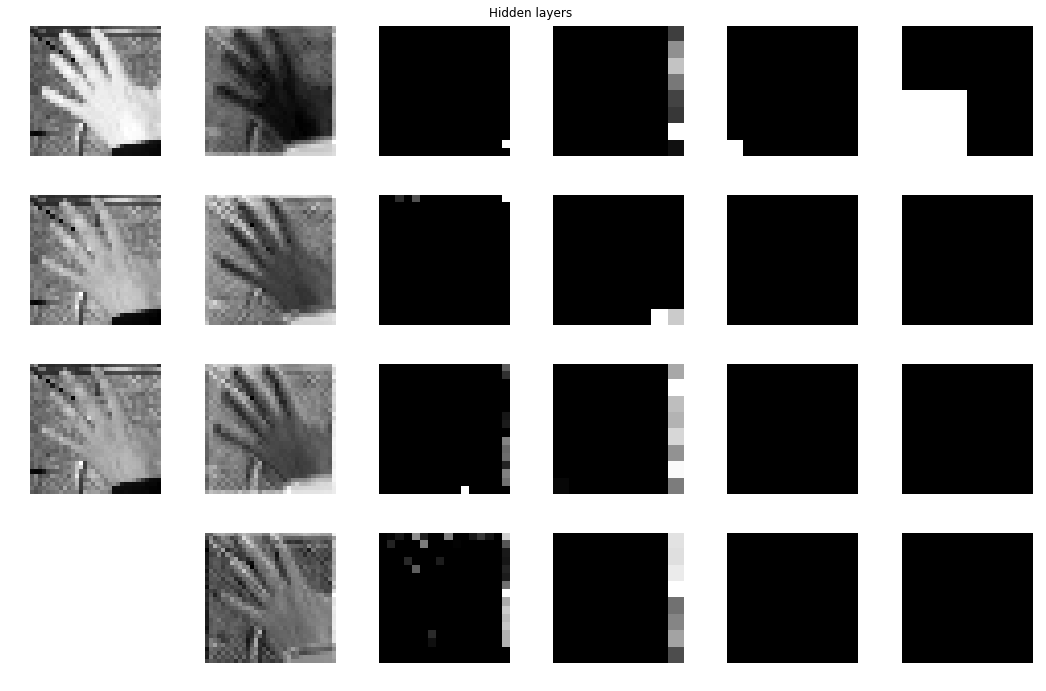

In [36]:
from keras import backend as K

def plot_hidden_layers(imt,nmaps=4):
    fig = plt.figure(figsize=(15, 10))
    plt.title('Hidden layers', loc='center')
    plt.axis('off')
    layers = [model.layers[0].input] + [model.layers[i].output for i in [0,2,5,7,9]]
    for layeri,layer in enumerate(layers):
        get = K.function([model.layers[0].input], [layer])
        layeroutputs = get([imt[np.newaxis,:,:,:]])[0][0]
        for j in range(nmaps): # for each map
            sp2=fig.add_subplot(nmaps,len(layers),layeri+1+j*len(layers))
            sp2.axis('off')
            if (layeroutputs.shape[2]>j):
                vmin,vmax = ((0,1) if layeri == 0 else (-0.3,+0.3))
                sp2.imshow(layeroutputs[:,:,j],
                           cmap="gray",
                           interpolation="nearest")
    fig.tight_layout()

imt=transform(dataset_te["image"].iloc[0],patchsize)
plot_hidden_layers(imt)


## We now search for the inputs maximizing a given neuron or set of neurons

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 32, 32, 96)        2688      
_________________________________________________________________
activation_96 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 16, 16, 192)       166080    
_________________________________________________________________
activation_97 (Activation)   (None, 16, 16, 192)       0         
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 8, 8, 192)         0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 8, 8, 384)         663936    
__________

In [38]:
def makeinputmaximizing(loss, gradstep = 0.01, steps = 20):
    grads = K.gradients(loss, model.input)[0]
    grads /= K.sqrt(K.mean(K.square(grads)) + 1e-5)
    iterate = K.function([model.input],[loss, grads])

    # img = transform_simple(dataset_te["image"].iloc[0],patchsize)[np.newaxis,:,:,:]
    img = 0.5+0.01*np.random.rand(1,patchsize,patchsize,3)
    
    for i in range(steps):
        loss_value, grads_value = iterate([img])
        img += grads_value * gradstep
        img = np.clip(img,0,1)
    return img[0,:,:,:]

In [39]:
plt.imshow(makeinputmaximizing(model.layers[16].output[0,2], steps = 1000, gradstep = 0.1))

IndexError: list index out of range

100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


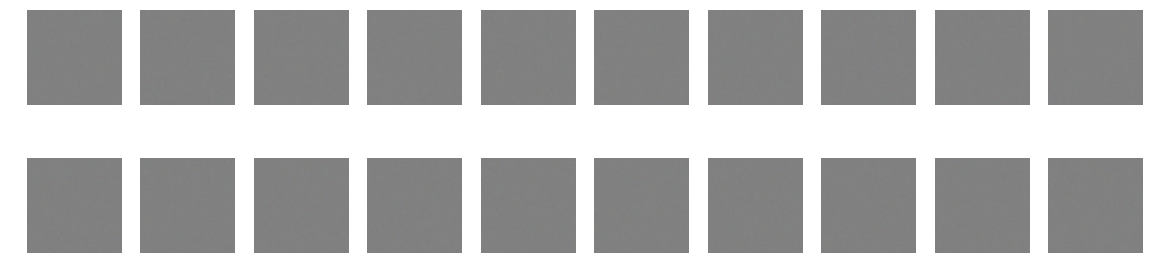

In [40]:
import tqdm
out = model.layers[12].output
fig, axs = plt.subplots(nrows = 2, ncols = 10, figsize=(20,5), squeeze = False)
for i,j in tqdm.tqdm(list(itertools.product(range(axs.shape[0]), range(axs.shape[1])))):
    loss = K.mean(out[:,j])
    img = makeinputmaximizing(loss, gradstep = 0.03, steps = 20)
    axs[i,j].imshow(img)
    axs[i,j].axis("off")

## Let us look for the 'ideal paper', according to the convnet

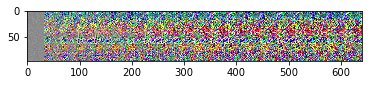

In [46]:
#oppure: 
#out = model.output

from keras import layers

iterations=20

input_shape=model.input.shape[1]
nc=model.output_shape[1]
final_output=np.zeros((input_shape*nc, input_shape*iterations, model.input.shape[3]))

B=32
for k in range(nc):
    step=1
    X=np.random.random((1, input_shape, input_shape, model.input.shape[3]))*0.1+0.5
    ideal=0
    objective = model.output[0,k]        
    c=K.gradients(objective, model.input)[0]
    get=K.function([model.input, K.learning_phase()],[objective, c])
    A=0
        
    for j in range(iterations):
        loss_value, grads_value=get([X, 1])
        final_output[input_shape*k:input_shape*(k+1),A:A+B]=X[0]
        step=1/np.max(grads_value)            
        X += grads_value*step
        A+=B
        X=np.clip(X, 0, 1)
plt.imshow(final_output[:,:,:], vmin=0, vmax=1)
    



## Let us locate the gesture in the image
- First, we feed an image of a paper gesture to the network;
- Second, we assign to each channel in the output of the last convolution a value corresponding ot its contribution to the class "paper";
- Third, we consider which parts in the input image activate the channels that lead to the decision: this is a paper. 

(32, 32)


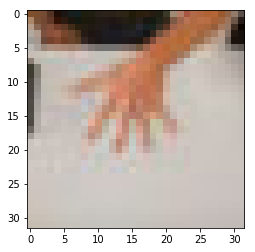

In [77]:
import cv2

img=skimage.img_as_float(skimage.io.imread("paper.jpg"))
img=np.expand_dims(img, axis=0)
preds=model.predict(img)
rps_output=model.output[:, np.argmax(preds[0])]
last_conv_layer=model.get_layer('conv2d_60')
grads=K.gradients(rps_output, last_conv_layer.output)[0]
pooled_grads=K.mean(grads, axis=(0, 1, 2))

iterate=K.function([model.input, K.learning_phase()], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img, 1])
##
for i in range(5):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap=cv2.resize(heatmap, (img.shape[1], img.shape[2]))
plt.imshow(heatmap)
print(heatmap.shape)

img=skimage.img_as_float(skimage.io.imread("paper.jpg"))
heatmap=np.expand_dims(heatmap, axis=3)
superimposed_img= np.clip(img + heatmap * 0.4, 0, 1)
plt.imshow(superimposed_img)
